Proyecto Megaline
El objetivo de este proyecto es analizar una base de datos de Megalinea sobre llamadas, para ello se limpiaran los datos y se analizaran. 

## Inicialización

In [1]:
# Cargar todas las librerías

from scipy import stats as st
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np
import math #para convertir mb en gygabytes 


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')
users = pd.read_csv('/datasets/megaline_users.csv')
plans  = pd.read_csv('/datasets/megaline_plans.csv')
messages =  pd.read_csv('/datasets/megaline_messages.csv') 
internet = pd.read_csv('/datasets/megaline_internet.csv') 


## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
display (plans)
plans.info

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


<bound method DataFrame.info of    messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  >

In [4]:
display(plans.dtypes)

messages_included          int64
mb_per_month_included      int64
minutes_included           int64
usd_monthly_pay            int64
usd_per_gb                 int64
usd_per_message          float64
usd_per_minute           float64
plan_name                 object
dtype: object


Los datos de las tarifas son informativos, la mayoria esta en int fuera del costo por mensaje y minuto. No hay datos ausentes
al ser un data frame de 2 lineas

## Usuarios/as

In [5]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

users.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
# Imprime una muestra de datos para usuarios
display(users.sample(10))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
239,1239,Quentin,Hancock,24,"Fresno, CA MSA",2018-08-11,surf,NaN
225,1225,Margarito,Barker,41,"Columbia, SC MSA",2018-06-07,surf,NaN
70,1070,Jacelyn,Contreras,66,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-05-12,surf,NaN
151,1151,Ralph,Monroe,21,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-03-20,surf,NaN
449,1449,Boyd,Kelley,39,"Seattle-Tacoma-Bellevue, WA MSA",2018-10-04,surf,NaN
55,1055,Patrick,Mclean,52,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-01-13,surf,NaN
457,1457,Janean,Lynch,47,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-17,surf,NaN
472,1472,Maximo,Mendoza,51,"San Francisco-Oakland-Berkeley, CA MSA",2018-04-10,surf,NaN
376,1376,Mika,Williams,58,"Columbia, SC MSA",2018-04-16,ultimate,NaN
489,1489,Londa,Jenkins,72,"Detroit-Warren-Dearborn, MI MSA",2018-05-24,surf,NaN


In [7]:
#Verificamos datos duplicados en la columna de user ID que es la que debe ser unica
#usamos duplicated ya que en este caso es imposible tengamos diferencias en esa columna por typos.
display (users['user_id'].duplicated().sum()) 


0

In [8]:
#ahora checamos duplicados en la combinacion de nombre y apellido, por seguridad si hay homonimos. 
NombreCompleto = ['first_name', 'last_name']
FilasDuplicadas = users[users.duplicated(subset=NombreCompleto, keep=False)]
display (FilasDuplicadas) 

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date


Los datos estan bien, para el analisis hay algunos que podemos consolidar como lo es el nombre con el apellido para buscar duplicados.

para el analisis. Igualmente reg_date y chuirn_date son de tipo object asi que habria que cambiarlos a datetime. 
Asi mismo para facilitar el analisis habria que agregar una columna de duracion si fuera relevante ver una comparacion
de cuando recien contratan a los otros meses. 

[Describe lo que ves y observas en la información general y en la muestra de datos impresa para el precio de datos anterior. ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

### Corregir los datos

In [9]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d') 
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d') 
users.info()
#con eso se pasa reg date y churn date a modo date time


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


## Llamadas

In [10]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

calls.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
# Imprime una muestra de datos para las llamadas
display(calls.sample(10))

,id,user_id,call_date,duration
83678,1305_99,1305,2018-08-02,12.03
36499,1138_460,1138,2018-10-28,2.68
58014,1209_545,1209,2018-10-23,7.54
62327,1223_510,1223,2018-07-19,6.76
98215,1352_680,1352,2018-11-01,15.62
105202,1370_421,1370,2018-09-28,3.62
79465,1284_834,1284,2018-10-16,1.53
57387,1206_119,1206,2018-11-01,13.27
45363,1164_62,1164,2018-10-29,6.75
96975,1346_201,1346,2018-07-01,14.36


In [12]:
#revisar duplicados en la columna donde no debe de haber que es id 
display (calls['id'].duplicated().sum()) 
#revisamos cuantos user_id tenemos esto porque tenemos 500 clientes y si hay clientes que no hacen llamadas
#es necesario saberlo para poder considerar que habra valores NaN en futuras tablas 
display( calls['user_id'].nunique())

0

481

No hay datos duplicados en columnas relevantes o ausentes. 
Igual que la tabla anterior hay que cambiar call_date a datetime para facilidad de operaciones. 
Asi mismo duracion de la llamada puede potencialmente causar problemas
al estar en base 10 cuando esta como float lo cual puede complicar operaciones ya que el sistema de tiempo es base 60
Al ser base 60 operaciones de promedios y similares no se pueden hacer de forma directa en un float porque se harian en base 10. 
Ahora dado que tenemos valores de 1.80 minutos, podriamos hacer el calculo y solo reconvertir al final.
Para este estudio se mantendran asi los tiempos y si es necesario se actualizan. 
Hay 19 usuarios que no hicieron llamadas asi que esto se debe tomar en cuenta para cuando se compaginen las tablas

### Corregir los datos

In [13]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') 
display( calls.sample(10))

,id,user_id,call_date,duration
94529,1336_404,1336,2018-09-15,21.55
27192,1102_42,1102,2018-12-10,9.71
131231,1472_141,1472,2018-06-28,4.31
5084,1022_350,1022,2018-05-30,9.40
33668,1126_439,1126,2018-08-13,0.00
57166,1203_557,1203,2018-07-07,5.25
26952,1101_279,1101,2018-05-12,9.38
115265,1404_59,1404,2018-12-01,2.51
128539,1461_177,1461,2018-09-23,4.69
119947,1417_716,1417,2018-12-09,3.03


### Enriquecer los datos

In [14]:
#Dado que el analisis nos pide saber por mes, vamos a crear una columna donde tenemos por mes
#cada llamada
calls['mes'] = calls['call_date'].dt.month

## Mensajes

In [15]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes

messages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [16]:
# Imprime una muestra de datos para los mensajes
display(messages.sample(10))

,id,user_id,message_date
35956,1236_244,1236,2018-11-03
55363,1348_86,1348,2018-12-10
14564,1099_126,1099,2018-12-30
61817,1385_281,1385,2018-09-17
250,1002_176,1002,2018-12-12
39495,1257_48,1257,2018-07-08
32560,1203_205,1203,2018-05-06
38004,1251_56,1251,2018-04-17
10235,1076_545,1076,2018-08-16
65492,1421_77,1421,2018-10-26


In [17]:
#revisar duplicados en la columna donde no debe de haber que es id 
display (messages['id'].duplicated().sum()) 
#revisamos cuantos user_id tenemos esto porque tenemos 500 clientes y si hay clientes que no mandan mensajes
#es necesario saberlo para poder considerar que habra valores NaN en futuras tablas 
display( messages['user_id'].nunique())

0

402

No se ven datos duplicados o ausentes en los datos. 
Igualmente hay que cambiar los datos de tiempo al modo correcto. 
Hay 98 usuarios que no usan mensajes asi que esto se debe tomar en cuenta para cuando se compaginen las tablas

### Corregir los datos

In [18]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d') 

### Enriquecer los datos

In [19]:
#Dado que el analisis nos pide saber por mes, vamos a crear una columna donde tenemos por mes
#cada mensaje
messages['mes'] = messages['message_date'].dt.month

## Internet

In [20]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [21]:
# Imprime una muestra de datos para el tráfico de internet
display (internet.sample(10))


,id,user_id,session_date,mb_used
24371,1112_52,1112,2018-12-23,660.36
101069,1478_220,1478,2018-10-03,0.00
86499,1402_28,1402,2018-11-11,440.35
4388,1027_216,1027,2018-08-03,462.32
25987,1121_80,1121,2018-12-26,515.69
40974,1185_11,1185,2018-12-15,274.77
89822,1414_278,1414,2018-09-10,259.31
22506,1103_51,1103,2018-11-13,357.75
42053,1187_230,1187,2018-12-24,208.65
92627,1433_11,1433,2018-10-27,731.89


In [22]:
#Duplicados en ID que es el que es unico. 
display (internet['id'].duplicated().sum()) 
#revisamos cuantos user_id tenemos esto porque tenemos 500 clientes y si hay clientes que no usan internet
#es necesario saberlo para poder considerar que habra valores NaN en futuras tablas 
display( internet['user_id'].nunique())

0

489

No hay datos duplicados o ausentes. 
Igualmente hay que actualizar los datos de tiempo a formato tiempo.
Hay 11 usuarios que no usan internet asi que esto se debe tomar en cuenta para cuando se compaginen las tablas


### Corregir los datos

In [23]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d') 
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enriquecer los datos

In [24]:
#Dado que el analisis nos pide saber por mes, vamos a crear una columna donde tenemos por mes
#cada sesion, posteriormente se puede agrupar si es necesario 
internet['mes'] = internet['session_date'].dt.month


## Estudiar las condiciones de las tarifas

In [25]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
display (plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [26]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado. 
#se agrupan por user id y por mes la columna de id porque estamos contando numero de llamads
llamadasPorUsuario = calls.groupby (['user_id','mes'])['id'].count().reset_index(name='N_de_llamadas_mes')
display ( llamadasPorUsuario)

,user_id,mes,N_de_llamadas_mes
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [27]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
#aqui agrupamos igual pero usamos la suma de la columna duracion. 
minutosPorUsuario = calls.groupby (['user_id','mes'])['duration'].sum().reset_index(name='Minutos_mes')
display ( minutosPorUsuario)


,user_id,mes,Minutos_mes
0,1000,12,116.83
1,1001,8,171.14
2,1001,9,297.69
3,1001,10,374.11
4,1001,11,404.59
...,...,...,...
2253,1498,12,324.77
2254,1499,9,330.37
2255,1499,10,363.28
2256,1499,11,288.56


In [28]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
# se usa el mismo proceso que llamadas
MensajesPorUsuario = messages.groupby (['user_id','mes'])['id'].count().reset_index(name='N_de_mensajes_mes')
display ( MensajesPorUsuario)


,user_id,mes,N_de_mensajes_mes
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [29]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
#Se usa el mismo proceso que con los minutos ya que nos interesa el total de uso de internet. 
MBporUsuario = internet.groupby (['user_id','mes'])['mb_used'].sum().reset_index(name='MB_mes')
display ( MBporUsuario) 


,user_id,mes,MB_mes
0,1000,12,1901.47
1,1001,8,6919.15
2,1001,9,13314.82
3,1001,10,22330.49
4,1001,11,18504.30
...,...,...,...
2272,1498,12,23137.69
2273,1499,9,12984.76
2274,1499,10,19492.43
2275,1499,11,16813.83


In [30]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
# se va a hacer un merge usando user_id y mes 

ConsumoTotalUsuario = pd.merge(llamadasPorUsuario,minutosPorUsuario, on=['user_id','mes'], how = 'outer')
ConsumoTotalUsuario = pd.merge(ConsumoTotalUsuario,MensajesPorUsuario, on=['user_id','mes'], how = 'outer')
ConsumoTotalUsuario = pd.merge(ConsumoTotalUsuario,MBporUsuario, on=['user_id','mes'], how = 'outer')
#como en este caso nos va a dar muchos NaN en los usuarios que no tengan llamadas,mensjes, o uso de internet
#Estos NaN se pueden dejar ya que las funciones estadisticas o de suma no los consideran en los calculos asi que no van a sesgar los datos
#como si pasaria si los cambiamos por 0 

display (ConsumoTotalUsuario )
#2293 filas 

,user_id,mes,N_de_llamadas_mes,Minutos_mes,N_de_mensajes_mes,MB_mes
0,1000,12,16.0,116.83,11.0,1901.47
1,1001,8,27.0,171.14,30.0,6919.15
2,1001,9,49.0,297.69,44.0,13314.82
3,1001,10,65.0,374.11,53.0,22330.49
4,1001,11,64.0,404.59,36.0,18504.30
...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,13039.91
2289,1361,5,NaN,NaN,2.0,1519.69
2290,1482,10,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,233.17


In [31]:
# Añade la información de la tarifa
PlanDeCadaUsuario = users[['user_id','plan']] #extraemos solo esas dos columnas para evitar errores 
ConsumoTotalUsuario = pd.merge(ConsumoTotalUsuario,PlanDeCadaUsuario, on=['user_id'], how = 'left') 

In [32]:
#vamos a agregar una columna que sea del codigo de fila del data frame de plans, esto para poder eficientizar analisis
#se conserva la columna de plan como string por si es necesario tener el nombre
def CodificarPlan(plan):
    if plan == 'surf':
        return 0
    else:
        return 1  
ConsumoTotalUsuario['CodigoPlan']=ConsumoTotalUsuario['plan'].apply(CodificarPlan)

display (ConsumoTotalUsuario)

,user_id,mes,N_de_llamadas_mes,Minutos_mes,N_de_mensajes_mes,MB_mes,plan,CodigoPlan
0,1000,12,16.0,116.83,11.0,1901.47,ultimate,1
1,1001,8,27.0,171.14,30.0,6919.15,surf,0
2,1001,9,49.0,297.69,44.0,13314.82,surf,0
3,1001,10,65.0,374.11,53.0,22330.49,surf,0
4,1001,11,64.0,404.59,36.0,18504.30,surf,0
...,...,...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,13039.91,surf,0
2289,1361,5,NaN,NaN,2.0,1519.69,surf,0
2290,1482,10,NaN,NaN,2.0,NaN,ultimate,1
2291,1108,12,NaN,NaN,NaN,233.17,ultimate,1


In [33]:
# Calcula el ingreso mensual para cada usuario
#Para ello usamos una funcion que va a trabajar con cada linea.
#va a verificar en cada mes cuanto gasto el usuario, comparar con el plan y dar un monton final 

In [34]:

def IngresoPorUsuario(row):
    MonthlyIncome = 0
    if row['Minutos_mes'] > plans.loc[row['CodigoPlan']]['minutes_included']:
        ExcesoDeLlamadas = row['Minutos_mes'] - plans.loc[row['CodigoPlan']]['minutes_included']
        MonthlyIncome = ExcesoDeLlamadas *  plans.loc[row['CodigoPlan']]['usd_per_minute']

        #dado que la funcion se ejecuta en orden, esta solo cambiara el 0 si se pasa
    #ahora repetimos para mensajes    
    
    if row['N_de_mensajes_mes'] > plans.loc[row['CodigoPlan']]['messages_included']:
        ExcesoDeMensajes = row['N_de_mensajes_mes'] - plans.loc[row['CodigoPlan']]['messages_included']
        MonthlyIncome = MonthlyIncome + (ExcesoDeMensajes *  plans.loc[row['CodigoPlan']]['usd_per_message'])
        #ahora que si podemos tener un valor diferente en monthly income hay que sumar el valor anterior. 
        #repetimos con megabytes
        
    if row['MB_mes'] > plans.loc[row['CodigoPlan']]['mb_per_month_included']:
        ExcesoDeMB = row['MB_mes'] - plans.loc[row['CodigoPlan']]['mb_per_month_included']
        gygabytes = math.ceil(ExcesoDeMB/1024)                
                        #aqui hay que convertir a gygabytes redondeando hacia arriba                 
        MonthlyIncome = MonthlyIncome + (gygabytes *  plans.loc[row['CodigoPlan']]['usd_per_gb'])

    MonthlyIncome = MonthlyIncome + plans.loc[row['CodigoPlan']]['usd_monthly_pay']
    return MonthlyIncome

In [35]:
#Primero cambiamos a cero en la muestra que se le aplicara la funcion 
#ConsumoTotalUsuarioIngresos = ConsumoTotalUsuario

#aplicamos la funcion 
ConsumoTotalUsuario['IngresoGenerado'] = ConsumoTotalUsuario.apply(IngresoPorUsuario, axis=1)
display (ConsumoTotalUsuario.sample(10))

,user_id,mes,N_de_llamadas_mes,Minutos_mes,N_de_mensajes_mes,MB_mes,plan,CodigoPlan,IngresoGenerado
1120,1245,11,29.0,169.36,15.0,12283.49,surf,0,20.0000
198,1049,7,44.0,280.21,NaN,8510.51,surf,0,20.0000
882,1187,12,74.0,555.38,8.0,21052.81,surf,0,81.6614
927,1198,9,51.0,403.34,7.0,13162.26,surf,0,20.0000
1006,1215,12,129.0,1108.45,98.0,34298.28,surf,0,229.6935
1985,1434,10,60.0,441.92,46.0,12090.00,surf,0,20.0000
1114,1244,11,17.0,143.78,33.0,20203.12,surf,0,70.0000
1828,1400,9,72.0,571.52,NaN,14336.67,surf,0,22.1456
1141,1249,8,96.0,518.52,39.0,18809.16,ultimate,1,70.0000
675,1146,10,39.0,206.48,43.0,11661.46,surf,0,20.0000


## Estudia el comportamiento de usuario

### Llamadas

In [36]:
#debido a que las graficas son mas leibles con el nombre del mes en lugar del numero vamos a agregar una columna de codigo mes 
CambioMes = {
    1: 'Ene',
    2: 'Feb',
    3: 'Mar',
    4: 'Abr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Ago',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

# agregamos 
ConsumoTotalUsuario['CodigoMes'] = ConsumoTotalUsuario['mes'].map(CambioMes)
ConsumoTotalUsuario = ConsumoTotalUsuario.sort_values(by = 'mes')


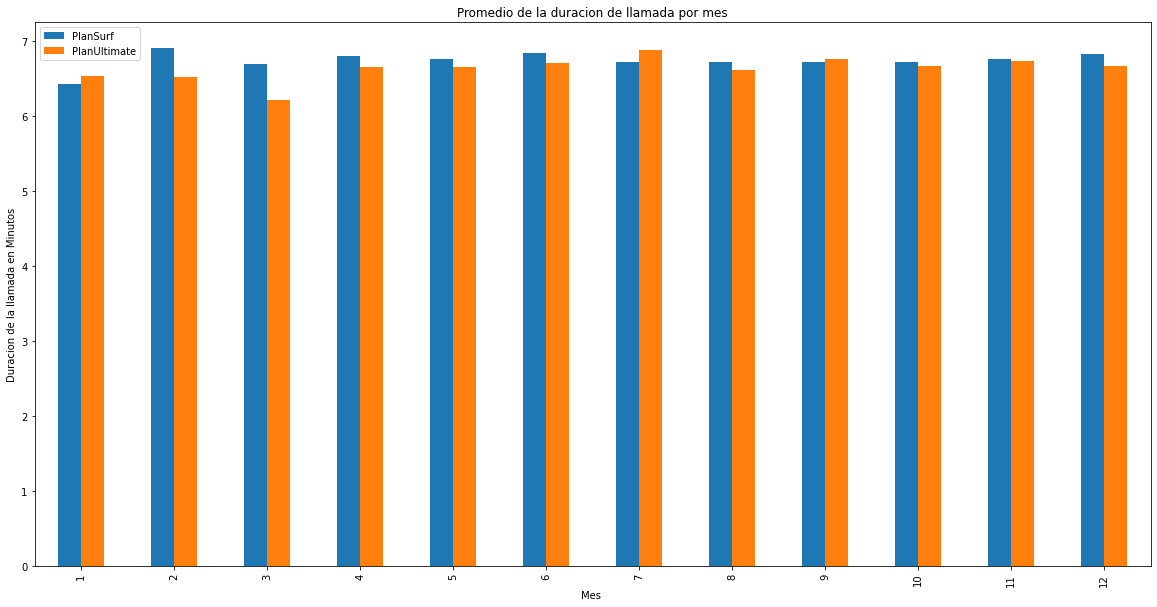

In [37]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
#Primero vamos a separar por plan. 
PlanSurfAislado = ConsumoTotalUsuario[ConsumoTotalUsuario['plan']== 'surf']
PlanUltimateAislado = ConsumoTotalUsuario[ConsumoTotalUsuario['plan']== 'ultimate']

#Para esto vamos a calcular la duracion promedio de los minutos y posteriormente el numero de llamadas promedio. 
PromedioMinutosPlanSurf = PlanSurfAislado.groupby('mes')['Minutos_mes'].mean()

PromedioMinutosPlanSurf = PromedioMinutosPlanSurf.rename('PlanSurf Minutos' )
PromedioLlamadasPlanSurf = PlanSurfAislado.groupby('mes')['N_de_llamadas_mes'].mean()
PromedioLlamadasPlanSurf = PromedioLlamadasPlanSurf.rename('PlanSurf Llamadas' )

#procedemos a los mismo con el plan ultimate 
PromedioMinutosPlanUltimate = PlanUltimateAislado.groupby('mes')['Minutos_mes'].mean()
PromedioMinutosPlanUltimate = PromedioMinutosPlanUltimate.rename('PlanUltimate Minutos' )
PromedioLlamadasPlanUltimate = PlanUltimateAislado.groupby('mes')['N_de_llamadas_mes'].mean()
PromedioLlamadasPlanUltimate = PromedioLlamadasPlanUltimate.rename('PlanUltimate Llamadas' )
#Ahora procedemos a dividirlas entre si. 

PromedioMixtoSurf  = PromedioMinutosPlanSurf / PromedioLlamadasPlanSurf 
PromedioMixtoSurf = PromedioMixtoSurf.rename('PlanSurf' )
PromedioMixtoUltimate =  PromedioMinutosPlanUltimate / PromedioLlamadasPlanUltimate  
PromedioMixtoUltimate = PromedioMixtoUltimate.rename('PlanUltimate' )


mezcla = pd.concat([PromedioMixtoSurf,PromedioMixtoUltimate], axis = 'columns') #juntamos 
cols = ['PlanSurf', 'PlanUltimate']  #nombres de las columnas para que no se encimen 
mezcla.plot(    #si no se pone X se toma el indice como default 
        y = cols, 
        title='Promedio de la duracion de llamada por mes',
        kind = 'bar',
        xlabel='Mes ',
        ylabel='Duracion de la llamada en Minutos',
         figsize=(20, 10))
# escribe tu código aquí

plt.legend(['PlanSurf','PlanUltimate'])

plt.show()




Podemos ver que el promedio de las llamadas es de poco mas de 6 minutos. Independientemente del plan. 

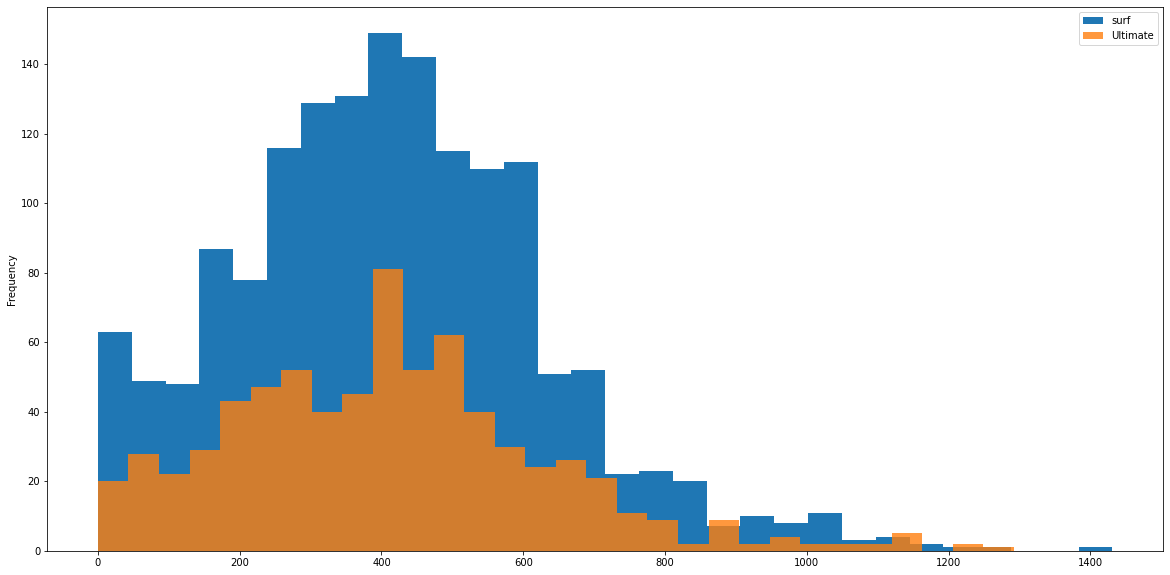

In [38]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
#se hace el histograma, podemos reusar nuestra columna CodigoPlan Para facilitar el codigo 
ConsumoTotalUsuario[ConsumoTotalUsuario['CodigoPlan']==0]['Minutos_mes'].plot(kind = 'hist',bins= 30, figsize=(20, 10))
ConsumoTotalUsuario[ConsumoTotalUsuario['CodigoPlan']==1]['Minutos_mes'].plot(kind = 'hist',bins= 30,alpha=0.8, figsize=(20, 10))
#se usa un alfa para ver ambos al mismo tiempo. 
plt.legend(['surf', 'Ultimate'])
plt.show() 



Se trazo un histograma y podemos ver que la mayoria e las llamdas caen en el rango de 400-500. Dicho esto seria interesante ver una comparacion con un grafico de barras donde veamos el promedio por mes ya que esto puede variar o darnos mas certeza de lo qu estamos viendo 

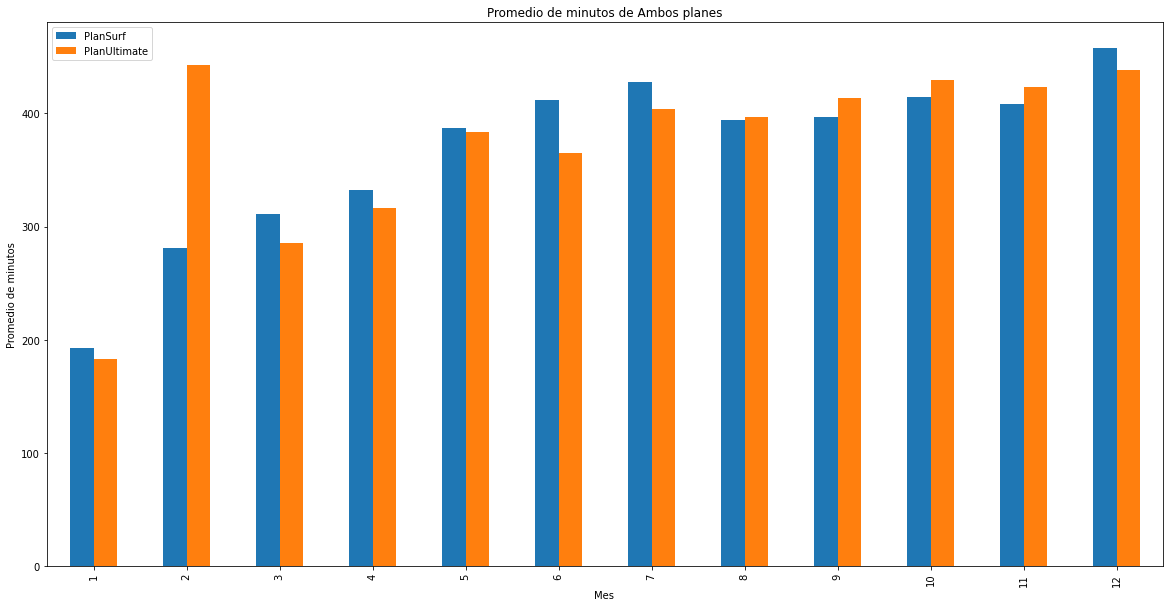

In [39]:
PlanSurfMinutosAlMes2 = PlanSurfAislado.groupby(by = 'mes')['Minutos_mes'].mean() 

PlanSurfMinutosAlMes2 = PlanSurfMinutosAlMes2.rename('PlanSurf') 

PlanUltimateMinutosAlMes2 = PlanUltimateAislado.groupby(by = 'mes')['Minutos_mes'].mean() 

PlanUltimateMinutosAlMes2 = PlanUltimateMinutosAlMes2.rename('PlanUltimate') 


PromedioMensualLlamadasAmbosPlanes = pd.concat([PlanSurfMinutosAlMes2,PlanUltimateMinutosAlMes2], axis = 'columns') #juntamos 

cols = ['PlanSurf', 'PlanUltimate']
PromedioMensualLlamadasAmbosPlanes.plot(   
        y = cols, 
        title='Promedio de minutos de Ambos planes',
        kind = 'bar',
        xlabel='Mes ',
        ylabel='Promedio de minutos',
        figsize=(20, 10))


plt.legend(['PlanSurf','PlanUltimate'])

plt.show()


En esta visualizacion por mes podemos ver que el promedio de minutos usados cada mes varia por plan donde los ususarios de surf usan menos minutos al mes excepto en navidad mientras que los usuarios de ultimate usan numeros similares todo el anio

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [40]:
display(ConsumoTotalUsuario)

,user_id,mes,N_de_llamadas_mes,Minutos_mes,N_de_mensajes_mes,MB_mes,plan,CodigoPlan,IngresoGenerado,CodigoMes
913,1196,1,42.0,272.56,23.0,8908.61,ultimate,1,70.000,Ene
155,1042,1,18.0,106.83,NaN,1854.93,surf,0,20.000,Ene
360,1077,1,42.0,275.07,37.0,10635.64,ultimate,1,70.000,Ene
1642,1362,1,42.0,278.85,21.0,7894.79,surf,0,20.000,Ene
861,1185,1,23.0,170.29,NaN,6812.77,ultimate,1,70.000,Ene
...,...,...,...,...,...,...,...,...,...,...
1294,1281,12,88.0,609.80,38.0,8169.07,surf,0,23.294,Dec
1296,1282,12,74.0,435.55,NaN,24487.10,ultimate,1,70.000,Dec
1298,1283,12,122.0,881.77,117.0,33067.50,ultimate,1,91.000,Dec
1262,1273,12,56.0,399.98,52.0,18176.59,ultimate,1,70.000,Dec


In [41]:
# Calcula la media y la varianza de la duración mensual de llamadas.
#aqui se probo ver la media y varianza de tanto juntos como aislados cada plan pero al ser datos similares se uso solo la del
#conjunto de ambos 
MediaDuracionLlamadasConjunto = ConsumoTotalUsuario['Minutos_mes'].mean()
MediaDuracionMensualPlanSurf = PlanSurfAislado['Minutos_mes'].mean()
MediaDuracionMensualPlanUltimate = PlanUltimateAislado['Minutos_mes'].mean()
#varianzas 

VarDuracionLlamadasConjunto =np.var(ConsumoTotalUsuario['Minutos_mes'])
VarDuracionMensualPlanSurf = np.var(PlanSurfAislado['Minutos_mes'])
VarDuracionMensualPlanUltimate = np.var(PlanUltimateAislado['Minutos_mes'])


# se usa print para que el output sea mas ordenado

print ('La media de los planes en conjunto es', MediaDuracionLlamadasConjunto )
print ('La media del plan surf es ', MediaDuracionMensualPlanSurf )
print ('La media del plan ultimate es ', MediaDuracionMensualPlanUltimate )

print ('La varianza de los planes en conjunto es', VarDuracionLlamadasConjunto )
print ('La varianza del plan surf es ', VarDuracionMensualPlanSurf )
print ('La varianza del plan ultimate es ', VarDuracionMensualPlanUltimate )



La media de los planes en conjunto es 411.4925863596103
La media del plan surf es  412.0978899676375
La media del plan ultimate es  410.18095371669006
La varianza de los planes en conjunto es 48067.00576337274
La varianza del plan surf es  46970.83270700408
La varianza del plan ultimate es  50439.789304279766


Podemos ver que el comportamiento de ambos planes es muy similar. 

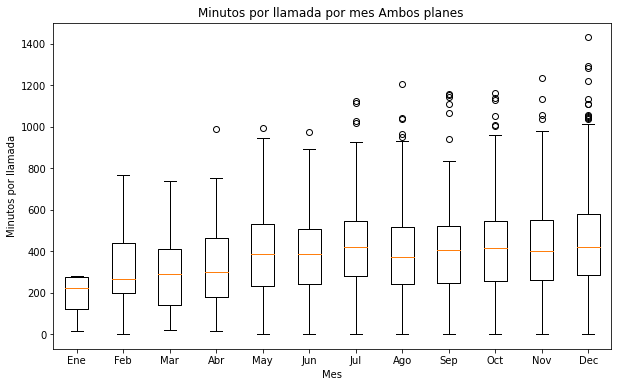

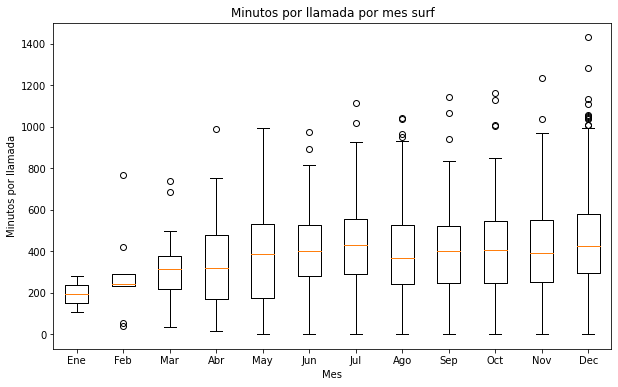

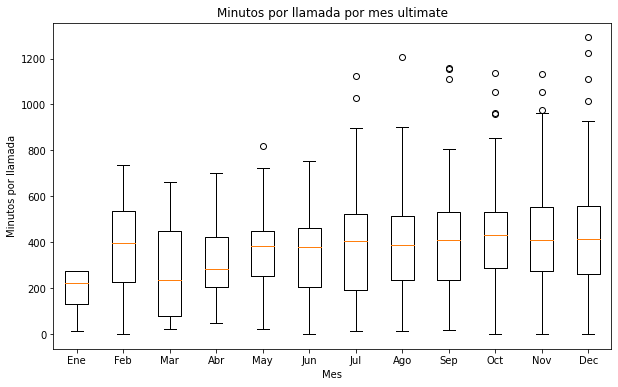

In [42]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
#para hacer un data frame de las llamadas en base al mes 
#Se tuvo que regresar a cambiar los resultados de NaN. Porque si no el box plot fallaba. 
NaNColumnas = ['N_de_llamadas_mes', 'Minutos_mes', 'N_de_mensajes_mes','MB_mes']
DiagramaOrdenada = ConsumoTotalUsuario.sort_values(by = 'mes') # para que el boxplot aparezca en orden
DiagramaOrdenada[NaNColumnas] = DiagramaOrdenada[NaNColumnas].fillna(0)





plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaOrdenada[DiagramaOrdenada['CodigoMes'] == mes]['Minutos_mes'] for mes in DiagramaOrdenada['CodigoMes'].unique()],
            labels=DiagramaOrdenada['CodigoMes'].unique())
plt.title('Minutos por llamada por mes Ambos planes ')
plt.xlabel('Mes')
plt.ylabel('Minutos por llamada')
plt.show()

DiagramaSurf = PlanSurfAislado.sort_values(by = 'mes') # para que el boxplot aparezca en orden
DiagramaSurf[NaNColumnas] = DiagramaSurf[NaNColumnas].fillna(0)

plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaSurf[DiagramaSurf['CodigoMes'] == mes]['Minutos_mes'] for mes in DiagramaSurf['CodigoMes'].unique()],
            labels=DiagramaSurf['CodigoMes'].unique())
plt.title('Minutos por llamada por mes surf')
plt.xlabel('Mes')
plt.ylabel('Minutos por llamada')
plt.show()


DiagramaUltimate = PlanUltimateAislado.sort_values(by = 'mes') # para que el boxplot aparezca en orden
DiagramaUltimate[NaNColumnas] = DiagramaUltimate[NaNColumnas].fillna(0)
plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaUltimate[DiagramaUltimate['CodigoMes'] == mes]['Minutos_mes'] for mes in DiagramaUltimate['CodigoMes'].unique()],
            labels=DiagramaUltimate['CodigoMes'].unique())
plt.title('Minutos por llamada por mes ultimate')
plt.xlabel('Mes')
plt.ylabel('Minutos por llamada')
plt.show()



Conclusiones de las llamadas
Despues de analizar los datos de los usuarios se puede concluir lo siguiente: 
1.Los usuarios de ambos planes tienen comportamientos similares, la mayoria usa 500 minutos o menos al mes.Este numero aumenta durante los meses de fiestas decembrinas. 
2. Los usuarios de Surf son mas propensos a pasarse de su limite de minutos, sobre todo en meses de fiestas. 
3. 

### Mensajes

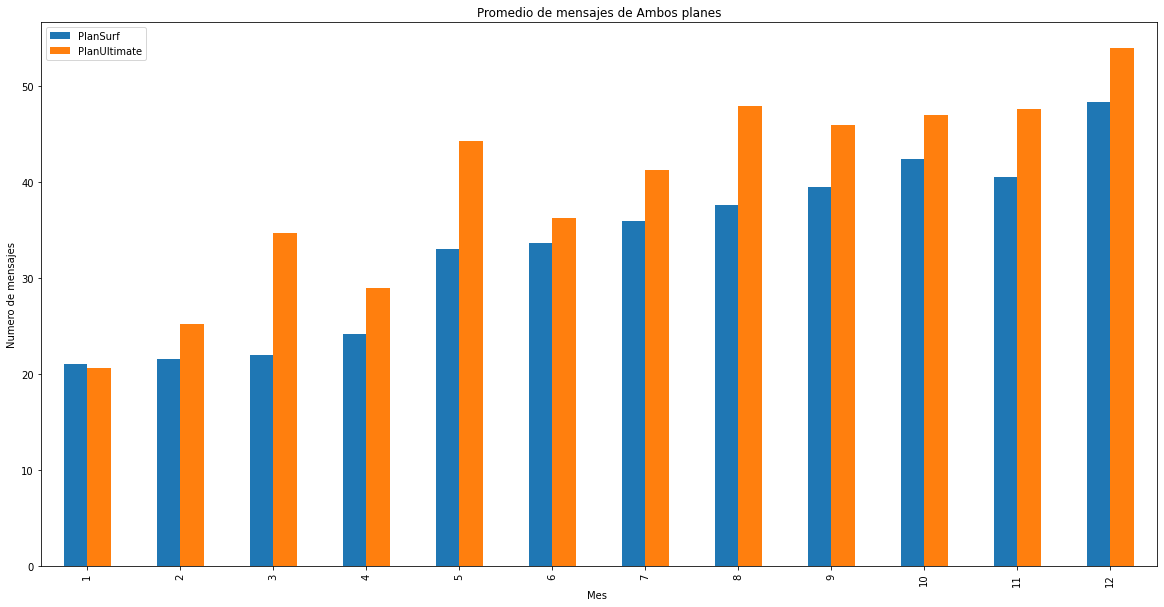

In [43]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan



#Para esto vamos a calcular el promedio de mensaje por mes 
PromedioMensajesPlanSurf = PlanSurfAislado.groupby('mes')['N_de_mensajes_mes'].mean()
PromedioMensajesPlanSurf = PromedioMensajesPlanSurf.rename('PlanSurf' )


#procedemos a los mismo con el plan ultimate 
PromedioMensajesPlanUltimate = PlanUltimateAislado.groupby('mes')['N_de_mensajes_mes'].mean()
PromedioMensajesPlanUltimate = PromedioMensajesPlanUltimate.rename('PlanUltimate' )



PromedioMensualMensajessAmbosPlanes = pd.concat([PromedioMensajesPlanSurf,PromedioMensajesPlanUltimate], axis = 'columns') #juntamos 

cols = ['PlanSurf', 'PlanUltimate']
PromedioMensualMensajessAmbosPlanes.plot(   
        y = cols, 
        title='Promedio de mensajes de Ambos planes',
        kind = 'bar',
        xlabel='Mes ',
        ylabel='Numero de mensajes',
        figsize=(20, 10))


plt.legend(['PlanSurf','PlanUltimate'])

plt.show()




Podemo ver que los usuarios del plan Surf usan menos mensajes que el plan en ambos casos se mantienen abajo de 50 en promedio. 
Una posible diferencia grande es que tanto usan mensajes en realidad los usuarios de surf para eso lo veremos con un histograma

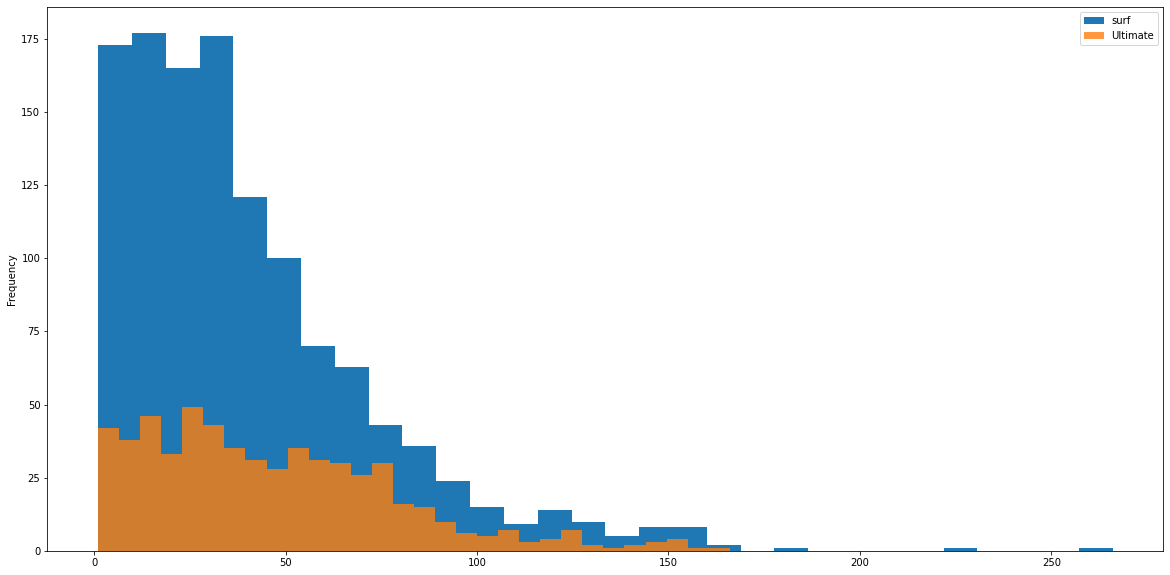

In [44]:
ConsumoTotalUsuario[ConsumoTotalUsuario['CodigoPlan']==0]['N_de_mensajes_mes'].plot(kind = 'hist',bins= 30, figsize=(20, 10))
ConsumoTotalUsuario[ConsumoTotalUsuario['CodigoPlan']==1]['N_de_mensajes_mes'].plot(kind = 'hist',bins= 30,alpha=0.8, figsize=(20, 10))
#se usa un alfa para ver ambos al mismo tiempo. 
plt.legend(['surf', 'Ultimate'])
plt.show() 

Podemos ver que los usuarios de surf es mas usual que manden pocos mensajes

In [45]:
#Vamos a ver la media y varianza de los mensajes 

MediaMensajesConjunto = ConsumoTotalUsuario['N_de_mensajes_mes'].mean()
MediaMensajesPlanSurf = PlanSurfAislado['N_de_mensajes_mes'].mean()
MediaMensajesalPlanUltimate = PlanUltimateAislado['N_de_mensajes_mes'].mean()
#varianzas 

VarMensajesConjunto =np.var(ConsumoTotalUsuario['N_de_mensajes_mes'])
VarMensajesPlanSurf = np.var(PlanSurfAislado['N_de_mensajes_mes'])
VarMensajesPlanUltimate = np.var(PlanUltimateAislado['N_de_mensajes_mes'])



#se usa print para que el output sea mas ordenado
print ('La media de los planes en conjunto es', MediaMensajesConjunto )
print ('La media del plan surf es ', MediaMensajesPlanSurf )
print ('La media del plan ultimate es ', MediaMensajesalPlanUltimate )

print ('La varianza de los planes en conjunto es', VarMensajesConjunto )
print ('La varianza del plan surf es ', VarMensajesPlanSurf )
print ('La varianza del plan ultimate es ', VarMensajesPlanUltimate )


La media de los planes en conjunto es 42.110188261351055
La media del plan surf es  40.10965630114566
La media del plan ultimate es  46.29623287671233
La varianza de los planes en conjunto es 1096.5210811384227
La varianza del plan surf es  1090.4511506183685
La varianza del plan ultimate es  1083.3249173156314


Podemos ver que al igual que con los mensajes no hay una variacion significativa entre ambos planes 

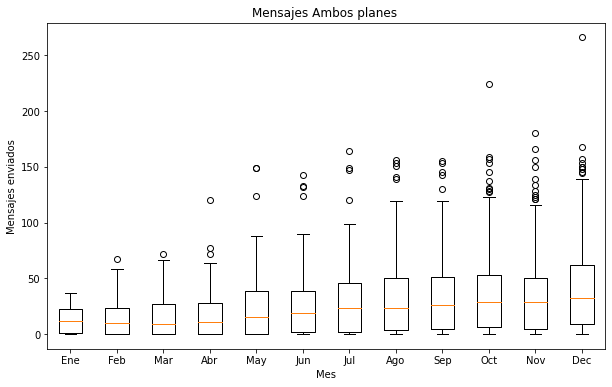

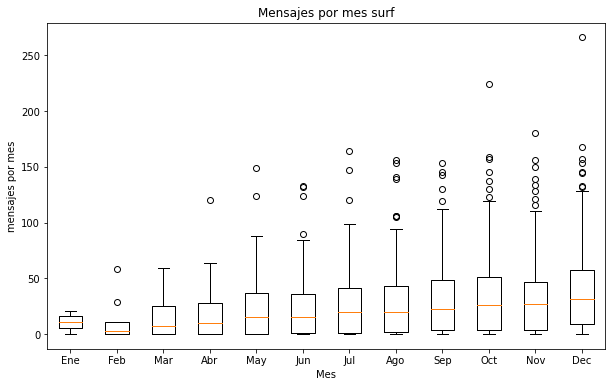

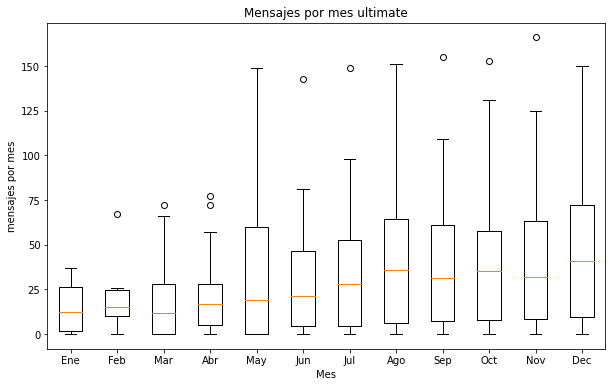

In [46]:
#finalmente vamos a ver un boxplot para ver las comparaciones entre los planes ya que en llamadas pudimos ver ciertos datos atipicos 

NaNColumnas = ['N_de_llamadas_mes', 'Minutos_mes', 'N_de_mensajes_mes','MB_mes'] 
DiagramaMensajes = ConsumoTotalUsuario.sort_values(by = 'mes') # para que el boxplot aparezca en orden

#no se porque en el dia anterior este funcionaba y ahora me lo pide declarar de nuevo

DiagramaMensajes[NaNColumnas] = DiagramaMensajes[NaNColumnas].fillna(0)


plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaMensajes[DiagramaMensajes['CodigoMes'] == mes]['N_de_mensajes_mes'] for mes in DiagramaMensajes['CodigoMes'].unique()],
            labels=DiagramaMensajes['CodigoMes'].unique())
plt.title('Mensajes Ambos planes ')
plt.xlabel('Mes')
plt.ylabel('Mensajes enviados')
plt.show() 


DiagramaSurfMensajes = PlanSurfAislado.sort_values(by = 'mes') # para que el boxplot aparezca en orden
DiagramaSurfMensajes[NaNColumnas] = DiagramaSurfMensajes[NaNColumnas].fillna(0)

plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaSurfMensajes[DiagramaSurfMensajes['CodigoMes'] == mes]['N_de_mensajes_mes'] for mes in DiagramaSurfMensajes['CodigoMes'].unique()],
            labels=DiagramaSurfMensajes['CodigoMes'].unique())
plt.title('Mensajes por mes surf')
plt.xlabel('Mes')
plt.ylabel('mensajes por mes')
plt.show()


DiagramaUltimateMensajes = PlanUltimateAislado.sort_values(by = 'mes') # para que el boxplot aparezca en orden
DiagramaUltimateMensajes[NaNColumnas] = DiagramaUltimateMensajes[NaNColumnas].fillna(0)

plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaUltimateMensajes[DiagramaUltimateMensajes['CodigoMes'] == mes]['N_de_mensajes_mes'] for mes in DiagramaUltimateMensajes['CodigoMes'].unique()],
            labels=DiagramaUltimateMensajes['CodigoMes'].unique())
plt.title('Mensajes por mes ultimate')
plt.xlabel('Mes')
plt.ylabel('mensajes por mes')
plt.show()

Conclusiones
1.En los mensajes podemos ver que los usuarios de ultimate nunca exceden el numero de mensajes que tienen.
2. Los usuarios de Surf en cambio es usual que excedan los 50 mensajes sobre todo en fechas de fiestas. La mayoria intenta mantenerse en el limte pero es mas comun que se excedan. 


### Internet

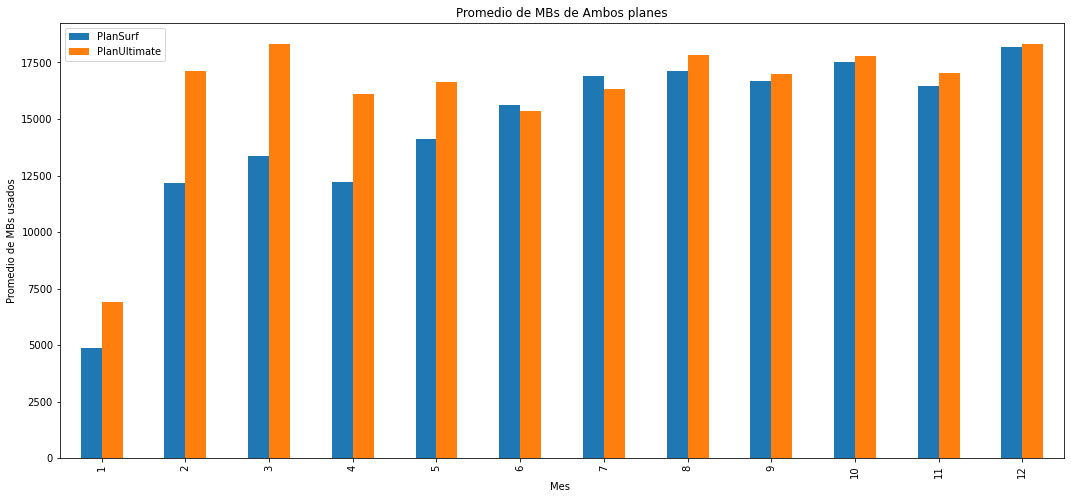

In [47]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan


#Para esto vamos a calcular el promedio de uso de internet por mes 
PromedioInternetPlanSurf = PlanSurfAislado.groupby('mes')['MB_mes'].mean()
PromedioInternetPlanSurf = PromedioInternetPlanSurf.rename('PlanSurf' )


#procedemos a los mismo con el plan ultimate 
PromedioInternetPlanUltimate = PlanUltimateAislado.groupby('mes')['MB_mes'].mean()
PromedioInternetPlanUltimate = PromedioInternetPlanUltimate.rename('PlanUltimate' )



PromedioInternetAmbosPlanes = pd.concat([PromedioInternetPlanSurf,PromedioInternetPlanUltimate], axis = 'columns') #juntamos 

cols = ['PlanSurf', 'PlanUltimate']
PromedioInternetAmbosPlanes.plot(   
        y = cols, 
        title='Promedio de MBs de Ambos planes',
        kind = 'bar',
        xlabel='Mes ',
        ylabel='Promedio de MBs usados', 
    figsize=(18, 8))


plt.legend(['PlanSurf','PlanUltimate'])

plt.show()









sabemos que en el caso de internet, los usuarios de surf tienen un limite de 15000 mb mientras que los de ultimate tienen un limite de 30000 mb. Con eso se puede concluir lo siguiente
1. Los usuarios de ultimate rara vez se pasan de su limite
2. los usuarios de surf, los primeros meses del anio se mantienen abajo de su limite pero conforme va terminando tienden a pasar por poco.



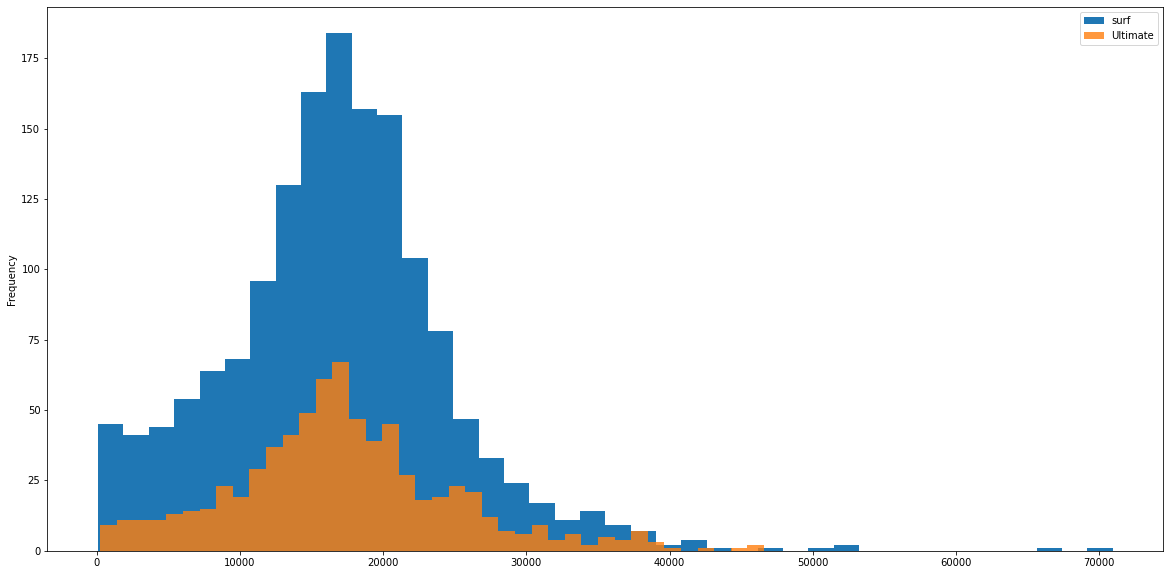

In [48]:
ConsumoTotalUsuario[ConsumoTotalUsuario['CodigoPlan']==0]['MB_mes'].plot(kind = 'hist',bins= 40, figsize=(20, 10))
ConsumoTotalUsuario[ConsumoTotalUsuario['CodigoPlan']==1]['MB_mes'].plot(kind = 'hist',bins= 40,alpha=0.8, figsize=(20, 10))
#se usa un alfa para ver ambos al mismo tiempo.  
plt.legend(['surf', 'Ultimate'])
plt.show() 


Podemos ver que hay algunos outliers de surf que se pasaron por mucho de la media de consumo de internet. Igualmente ultimate igual se llegan a pasar pero en menor proporcion

In [49]:
#vamos a calcular las medias y varianzas

MediaMBsConjunto = ConsumoTotalUsuario['MB_mes'].mean()
MediaMBsPlanSurf = PlanSurfAislado['MB_mes'].mean()
MediaMBsPlanUltimate = PlanUltimateAislado['MB_mes'].mean()
#varianzas 

VarMBsConjunto =np.var(ConsumoTotalUsuario['MB_mes'])
VarMBsPlanSurf = np.var(PlanSurfAislado['MB_mes'])
VarMBsPlanUltimate = np.var(PlanUltimateAislado['MB_mes'])



#aqui se uso print para que salga mas ordenado
print ('La media de los planes en conjunto es', MediaMBsConjunto )
print ('La media del plan surf es ', MediaMBsPlanSurf )
print ('La media del plan ultimate es ', MediaMBsPlanUltimate )

print ('La varianza de los planes en conjunto es', VarMBsConjunto )
print ('La varianza del plan surf es ', VarMBsPlanSurf )
print ('La varianza del plan ultimate es ', VarMBsPlanUltimate )

La media de los planes en conjunto es 16882.197501097937
La media del plan surf es  16717.702137355584
La media del plan ultimate es  17238.642253129346
La varianza de los planes en conjunto es 61906313.93878115
La varianza del plan surf es  62128323.16300872
La varianza del plan ultimate es  61239556.12006475


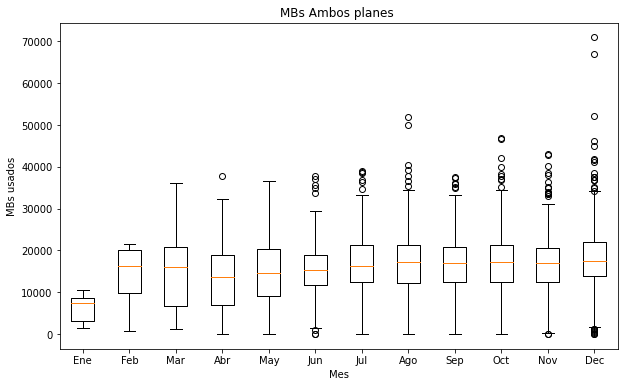

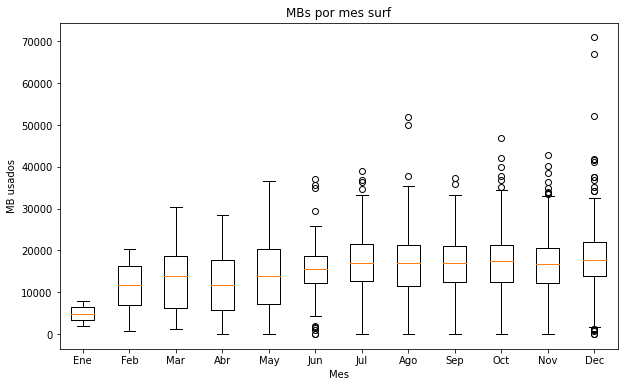

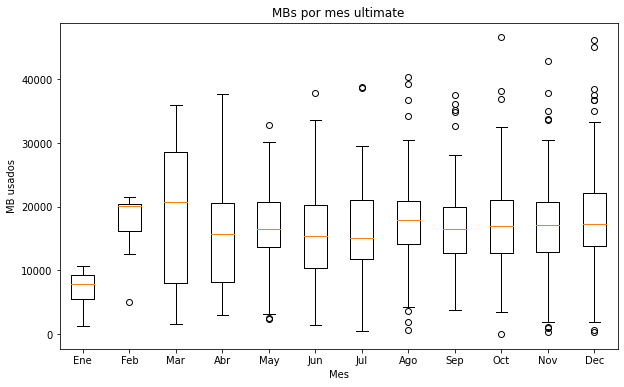

In [50]:
#finalmente un boxplot para poder ver la dispesion de los datos. 




NaNColumnas = ['N_de_llamadas_mes', 'Minutos_mes', 'N_de_mensajes_mes','MB_mes'] 
DiagramaMB = ConsumoTotalUsuario.sort_values(by = 'mes') # para que el boxplot aparezca en orden

#no se porque en el dia anterior este funcionaba y ahora me lo pide declarar de nuevo

DiagramaMB[NaNColumnas] = DiagramaMB[NaNColumnas].fillna(0)


plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaMB[DiagramaMB['CodigoMes'] == mes]['MB_mes'] for mes in DiagramaMB['CodigoMes'].unique()],
            labels=DiagramaMB['CodigoMes'].unique())
plt.title('MBs Ambos planes ')
plt.xlabel('Mes')
plt.ylabel('MBs usados')
plt.show() 


DiagramaSurfMB = PlanSurfAislado.sort_values(by = 'mes') # para que el boxplot aparezca en orden
DiagramaSurfMB[NaNColumnas] = DiagramaSurfMB[NaNColumnas].fillna(0)

plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaSurfMensajes[DiagramaSurfMensajes['CodigoMes'] == mes]['MB_mes'] for mes in DiagramaSurfMensajes['CodigoMes'].unique()],
            labels=DiagramaSurfMensajes['CodigoMes'].unique())
plt.title('MBs por mes surf')
plt.xlabel('Mes')
plt.ylabel('MB usados')
plt.show()


DiagramaUltimateMB= PlanUltimateAislado.sort_values(by = 'mes') # para que el boxplot aparezca en orden
DiagramaUltimateMB[NaNColumnas] = DiagramaUltimateMB[NaNColumnas].fillna(0)

plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaUltimateMB[DiagramaUltimateMB['CodigoMes'] == mes]['MB_mes'] for mes in DiagramaUltimateMB['CodigoMes'].unique()],
            labels=DiagramaUltimateMB['CodigoMes'].unique())
plt.title('MBs por mes ultimate')
plt.xlabel('Mes')
plt.ylabel('MB usados')
plt.show()






Conclusiones
1. Los usarios de surf tiended a usar menos internet que los usuarios de ultimate
2. los usuarios de ultimate es menos probable que excedan su limite de datos. 
3. En fechas decembrinas es cuando hay mas exceso de uso. 

## Ingreso

Con esto sabemos que 2/3 son usuarios surf y el resto ultimate. 

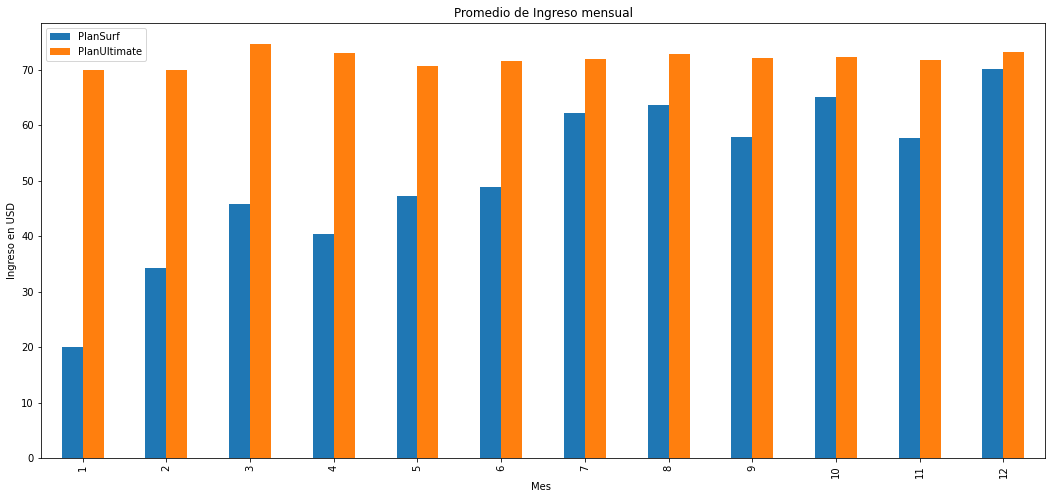

In [51]:
#Ahora calculamos el promedio de ingresos 

#Para esto vamos a calcular el promedio que genera cada uno. 
IngresoPlanSurf = PlanSurfAislado.groupby('mes')['IngresoGenerado'].mean()
IngresoPlanSurf = IngresoPlanSurf.rename('PlanSurf' )

#procedemos a los mismo con el plan ultimate 
IngresoPlanUltimate = PlanUltimateAislado.groupby('mes')['IngresoGenerado'].mean()
IngresoPlanUltimate = IngresoPlanUltimate.rename('PlanUltimate' )



IngresoAmbosPlanes = pd.concat([IngresoPlanSurf,IngresoPlanUltimate], axis = 'columns') #juntamos 

cols = ['PlanSurf', 'PlanUltimate']
IngresoAmbosPlanes.plot(   
        y = cols, 
        title='Promedio de Ingreso mensual',
        kind = 'bar',
        xlabel='Mes ',
        ylabel='Ingreso en USD', 
    figsize=(18, 8))


plt.legend(['PlanSurf','PlanUltimate'])

plt.show()


A priori podemos ver que los usuarios de surf es mas comun se pasen del limite de su plan. 

In [52]:
 #En ingresos nos sirve ver cual es el promedio y varianca de cada parte 
    
    
MediaIngresoT = ConsumoTotalUsuario['IngresoGenerado'].mean()
MediaIngresoSurf = PlanSurfAislado['IngresoGenerado'].mean()
MediaIngresoUltimate = PlanUltimateAislado['IngresoGenerado'].mean()
#varianzas 

VarIngresoTCon =np.var(ConsumoTotalUsuario['IngresoGenerado'])
VarIngresoSurf = np.var(PlanSurfAislado['IngresoGenerado'])
VarIngresoUlti = np.var(PlanUltimateAislado['IngresoGenerado'])



#aqui se uso print para que salga mas ordenado
print ('La media de los planes en conjunto es', MediaIngresoT )
print ('La media del plan surf es ', MediaIngresoSurf )
print ('La media del plan ultimate es ', MediaIngresoUltimate )

print ('La varianza de los planes en conjunto es', VarIngresoTCon )
print ('La varianza del plan surf es ', VarIngresoSurf )
print ('La varianza del plan ultimate es ', VarIngresoUlti )
    
    
    

La media de los planes en conjunto es 64.09111016136066
La media del plan surf es  60.32734621741895
La media del plan ultimate es  72.31388888888888
La varianza de los planes en conjunto es 2165.348533871458
La varianza del plan surf es  3052.013980691246
La varianza del plan ultimate es  129.66814043209877


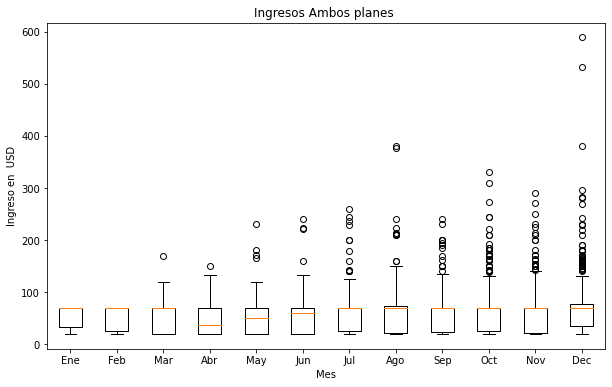

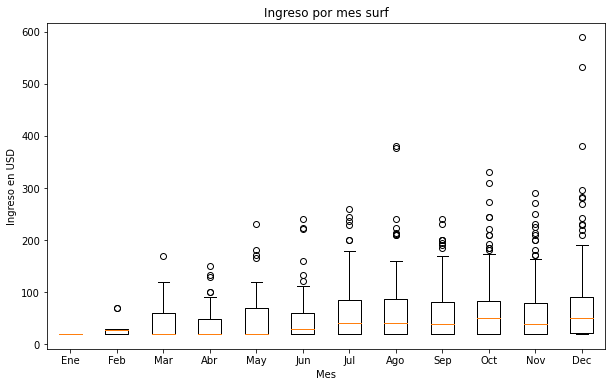

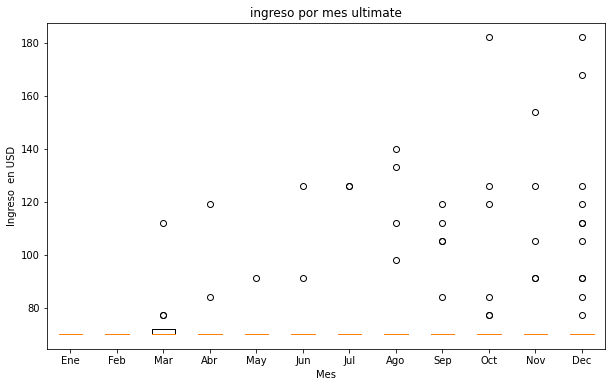

In [53]:
#por el tipo de media nos sirve verlos como box plot para evaluar su distribucion 


DiagramaIngresos = ConsumoTotalUsuario.sort_values(by = 'mes') # para que el boxplot aparezca en orden



plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaIngresos[DiagramaIngresos['CodigoMes'] == mes]['IngresoGenerado'] for mes in DiagramaIngresos['CodigoMes'].unique()],
            labels=DiagramaIngresos['CodigoMes'].unique())
plt.title('Ingresos Ambos planes ')
plt.xlabel('Mes')
plt.ylabel('Ingreso en  USD')
plt.show() 


DiagramaIngresosSurf = PlanSurfAislado.sort_values(by = 'mes') # para que el boxplot aparezca en orden


plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaIngresosSurf[DiagramaIngresosSurf['CodigoMes'] == mes]['IngresoGenerado'] for mes in DiagramaIngresosSurf['CodigoMes'].unique()],
            labels=DiagramaIngresosSurf['CodigoMes'].unique())
plt.title('Ingreso por mes surf')
plt.xlabel('Mes')
plt.ylabel('Ingreso en USD')
plt.show()


DiagramaUltimateIngresos = PlanUltimateAislado.sort_values(by = 'mes') # para que el boxplot aparezca en orden


plt.figure(figsize=(10, 6)) 
plt.boxplot([DiagramaUltimateIngresos[DiagramaUltimateIngresos['CodigoMes'] == mes]['IngresoGenerado'] for mes in DiagramaUltimateIngresos['CodigoMes'].unique()],
            labels=DiagramaUltimateIngresos['CodigoMes'].unique())
plt.title('ingreso por mes ultimate')
plt.xlabel('Mes')
plt.ylabel('Ingreso  en USD')
plt.show()







Conclusiones 
1. Los usuarios de Surf son mas propensos a pasarse del limite de su plan sobre todo en fechas decembrinas y por lo tanto pagar mas
2. los usuarios de ultimate rara vez se pasan fuera de algunos outliers cada mes. 

## Prueba las hipótesis estadísticas

# Prueba las hipótesis
Hipotesis nula: Los ingresos promedio de Ultimate y Surf son iguales.  
Hipotesis alternativa: Los ingresos promedio generados popr ultimate y surf son diferentes, una vez ajustados a sus proporciones
Aqui lo que buscamos es que el promedio de ingresos es diferente del promedio de otra poblacion estadistica. 

En esta prueba es necesario hablar del ajuste a proporcion. Como tenemos una muestra de solo 500 personas y tenemos que extrapolar a la poblacion total va a ser necesario calcular la siguiente informacion. 
1. Cuantos ingresos se generaron en total. 
2. Cuantos de ese total fueron por surf y por ultimate respectivamente.  
Podemos asumir que la muestra que se nos proporciono es equivalente a la poblacion general de 2/3 surf y 1/3 ultimate. 
Un elemento importante a considerar es cuantos usuarios habia en cada mes. 


In [54]:
#Primero vemos cuantos usuarios tenemos cada mes. 

#En el caso de los ingresos se tienen que tomar en cuenta varios factores
#El primero es cuantos usuarios hay de cada tipo y cuanto generan en promedio cada uno. 


NUsusariosSurfMes = PlanSurfAislado.groupby('mes')['user_id'].nunique()
NUsusariosSurfMes = NUsusariosSurfMes.rename('Usuarios por Mes Surf' )

NUsuariosUltimateMes = PlanUltimateAislado.groupby('mes')['user_id'].nunique()
NUsuariosUltimateMes = NUsuariosUltimateMes.rename('Usuarios Por Mes Ultimate' )

NUsuariosAlMes = ConsumoTotalUsuario.groupby('mes')['user_id'].nunique()
NUsuariosAlMes = NUsuariosAlMes.rename('Usuarios Por Mes' )

NUsuariosAlMesMer = pd.concat([NUsusariosSurfMes,NUsuariosUltimateMes,NUsuariosAlMes], axis = 'columns') #juntamos 


display( NUsuariosAlMesMer)


,Usuarios por Mes Surf,Usuarios Por Mes Ultimate,Usuarios Por Mes
mes,,,
1,2,4,6
2,9,7,16
3,23,12,35
4,50,21,71
5,77,29,106
6,97,47,144
7,121,59,180
8,162,71,233
9,194,86,280


In [55]:
# El primer paso es ver cuantos ingresos se generaron en total y por separado Surf y ultimate en cada mes. 

IngresoTotal = ConsumoTotalUsuario.groupby('mes')['IngresoGenerado'].sum() 
IngresoTotal = IngresoTotal.rename('IngresoTotalGenerado' )
IngresoSurf = PlanSurfAislado.groupby('mes')['IngresoGenerado'].sum()
IngresoSurf = IngresoSurf.rename('IngresoGeneradoSurf')
IngresoUltimate = PlanUltimateAislado.groupby('mes')['IngresoGenerado'].sum()
IngresoUltimate = IngresoUltimate.rename('IngresoGeneradoUltimate')
                                         
                                        
IngresoAlMesMer = pd.concat([IngresoSurf,IngresoUltimate,IngresoTotal], axis = 'columns') #juntamos 
#para el analisis nos sirve tenerlos con los usuarios por mes asi que se junta en una sola tabla ambas. 

IngresosCompleto= pd.concat([NUsusariosSurfMes, IngresoSurf, NUsuariosUltimateMes, IngresoUltimate,NUsuariosAlMes, IngresoTotal ] , axis = 'columns'        )
                                  
                                         
display(IngresosCompleto )                        
                                         




,Usuarios por Mes Surf,IngresoGeneradoSurf,Usuarios Por Mes Ultimate,IngresoGeneradoUltimate,Usuarios Por Mes,IngresoTotalGenerado
mes,,,,,,
1,2,40.0000,4,280.0,6,320.0000
2,9,308.3106,7,490.0,16,798.3106
3,23,1053.1760,12,896.0,35,1949.1760
4,50,2022.7350,21,1533.0,71,3555.7350
5,77,3637.1069,29,2051.0,106,5688.1069
6,97,4746.2813,47,3367.0,144,8113.2813
7,121,7528.8550,59,4242.0,180,11770.8550
8,162,10298.7550,71,5173.0,233,15471.7550
9,194,11242.0168,86,6195.0,280,17437.0168


In [56]:
#porcentaje de la ganancia que corresponde a cada uno. 
#Aqui lo que buscamos es ver que % del total poblacional representa cada uno. Ya que si bien uno puede dar 
#mas ingresos que otro, si la proporcion de clientes de cierto plan esta sobrepresentada esto puede indicar un sesgo

PorcentajeIngresoDeSurf = IngresosCompleto['IngresoGeneradoSurf']/IngresosCompleto['IngresoTotalGenerado'] 
PorcentajeIngresoDeSurf = PorcentajeIngresoDeSurf.rename('PorcentajeIngresosSurf' )
ProcentajeDeUltimate = 1- PorcentajeIngresoDeSurf 
PorcenProbSurf =  IngresosCompleto['Usuarios por Mes Surf']/IngresosCompleto['Usuarios Por Mes'] 
PorcenProbSurf = PorcenProbSurf.rename('PorcentajePobSurf' )

PorcentINgresoYPoblacion = pd.concat([PorcentajeIngresoDeSurf,PorcenProbSurf], axis = 'columns')
display ( PorcentINgresoYPoblacion)


,PorcentajeIngresosSurf,PorcentajePobSurf
mes,,
1,0.125000,0.333333
2,0.386204,0.562500
3,0.540319,0.657143
4,0.568866,0.704225
5,0.639423,0.726415
6,0.585001,0.673611
7,0.639618,0.672222
8,0.665649,0.695279
9,0.644721,0.692857


Aqui podemos ver que si bien el porcentaje de ingresos total que representa Surf aumenta y despues del segundo mes representa mas del 50% de los ingresos, el numero de clientes que son de Surf igual son mayoria. 

In [57]:
#ahora vamos a calcular los ingresos promedio

IngresoTotalMean = ConsumoTotalUsuario.groupby('mes')['IngresoGenerado'].mean() 
IngresoTotalMean = IngresoTotal.rename('IngresoPromedioGenerado' )
IngresoSurfMean = PlanSurfAislado.groupby('mes')['IngresoGenerado'].mean()
IngresoSurfMean = IngresoSurf.rename('IngresoPromedioSurf')
IngresoUltimateMean = PlanUltimateAislado.groupby('mes')['IngresoGenerado'].mean()
IngresoUltimateMean = IngresoUltimate.rename('IngresoPromedioUltimate')

PromedioIngresos = pd.concat([IngresoSurfMean,IngresoUltimateMean], axis = 'columns')
display ( PromedioIngresos)




,IngresoPromedioSurf,IngresoPromedioUltimate
mes,,
1,40.0000,280.0
2,308.3106,490.0
3,1053.1760,896.0
4,2022.7350,1533.0
5,3637.1069,2051.0
6,4746.2813,3367.0
7,7528.8550,4242.0
8,10298.7550,5173.0
9,11242.0168,6195.0


In [58]:
alpha = 0.05 # Elegimos 5% al ser el mas usual en estadistica, y que representa un 5% de rechazar la hipotesis nulla
#vamos a usar ttest_ind porque las dos variables son independientes entre si en cuanto a la cantidad de dinero que generan. 

resultado = st.ttest_ind(IngresosCompleto['IngresoGeneradoSurf'],IngresosCompleto['IngresoGeneradoUltimate'], equal_var =False)
display (resultado.pvalue)

if resultado.pvalue < alpha: # comparar el valor p con el umbral
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula") 


0.1461613707723021

No podemos rechazar la hipótesis nula


Conclusion
No podemos rechazar la hipotesis nula. Si bien el numero de ingresos que dan los usuarios del plan surf es mayor numericamente y mensualmente representa entre 55 y 60% de todos los ingresos, estos se pueden deber a que hay un mayor numero de usuarios de surf y que en promedio, se pasan de sus limites mensuales. 
Aun con el exceso de limites la tarifa base de los usuarios Ultimate hace que en proporcion sea equivalente a usuarios surf. 


[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

# Prueba las hipótesis
En esta pregunta queremos ver si el ingreso promedio de los usuarios de NY-NJ son diferentes de las otras regiones. Para ello primero creamos una hipotesis nula en la que se dice que los ingresos promedio son iguales, y la hipotesis alternativa en la que decimos que son diferentes. Dada la pregunta no sabemos si diferentes es que sean mayores o menores. 

Hipotesis nula: Los ingresos promedio de los usuarios de "New York-Newark-Jersey City, NY-NJ-PA MSA" son iguales a los de otras regiones.

Hipotesis alternativa: Los ingresos promedio generados por los usuarios de Ny-NJ son diferentes a los de otras regiones . 
Aqui buscamos comparar la poblacion de una region con la de otra por lo que es una hipotesis de la media de una poblacion estadistica es mayor o menor que la media de otras poblaciones estadisticas. En esta caso la media de NY contra las otras. En este caso se hara una prueba de dos colas 

En esta prueba se debe separar los usuarios de cada region y posteriormente hacer la comparacion. Para ello seguiremos los siguientes pasos: 
1. Se aisla del data frame los usuarios de cada ciudad y cuanto ingreso generaron. 
2. se agrupan por el numero de usuarios por ciudad y el ingreso total de esas ciudades. 
3. Se genera una grafica del ingreso total para poder ver cual es la region con mas ingreso.
4. Se saca el promedio de cada region dividiendo entre el numero de usuarios los ingresos totales y se grafica.
5. Finalmente se le hace una prueba de dos colas 


In [59]:
#Primero vamos a aislar los usuarios por region
#para ello vamos a hacer un data frame usando ConstumoTotalUsuario que es el general pero salvando solo las columnas relevantes
#que son user_id, Mes, Plan, INgreso GEnerado 

ColumnasUsuarios = ['user_id', 'city']
ColumnasIngresos = ['user_id', 'mes', 'plan','IngresoGenerado']

# Merge data frames on the specified columns
#IDConPoblacion = pd.merge(ConsumoTotalUsuario, users, left_on=ColumnasUsuarios )
IDConPoblacion = pd.merge(ConsumoTotalUsuario, users[['user_id', 'city']], on='user_id', how='left')
#columnas a eliminar
ColumnasNoImportantes = ['N_de_llamadas_mes','plan', 'Minutos_mes', 'N_de_mensajes_mes','MB_mes', 'CodigoPlan', 'CodigoMes' ]

IDConPoblacion = IDConPoblacion.drop(ColumnasNoImportantes, axis=1)



In [60]:
#ahora vamos a agrupar por ciudad para poder comparar. 
#para esto vamos a usar Agg
CiudadIngresoPorMes = IDConPoblacion.groupby(['city','mes']).agg({'user_id': 'nunique', 'IngresoGenerado': 'sum'}).reset_index() 
CiudadIngresoTotal = IDConPoblacion.groupby('city').agg({'user_id': 'nunique', 'IngresoGenerado': 'sum'}).reset_index() 

display(CiudadIngresoTotal )

,city,user_id,IngresoGenerado
0,"Albany-Schenectady-Troy, NY MSA",1,738.9226
1,"Albuquerque, NM MSA",2,945.3859
2,"Atlanta-Sandy Springs-Roswell, GA MSA",12,3526.2813
3,"Austin-Round Rock-Georgetown, TX MSA",5,1350.8319
4,"Bakersfield, CA MSA",4,390.0000
...,...,...,...
68,"Tucson, AZ MSA",2,650.0000
69,"Tulsa, OK MSA",2,678.5400
70,"Urban Honolulu, HI MSA",5,2360.4263
71,"Virginia Beach-Norfolk-Newport News, VA-NC MSA",4,390.0000


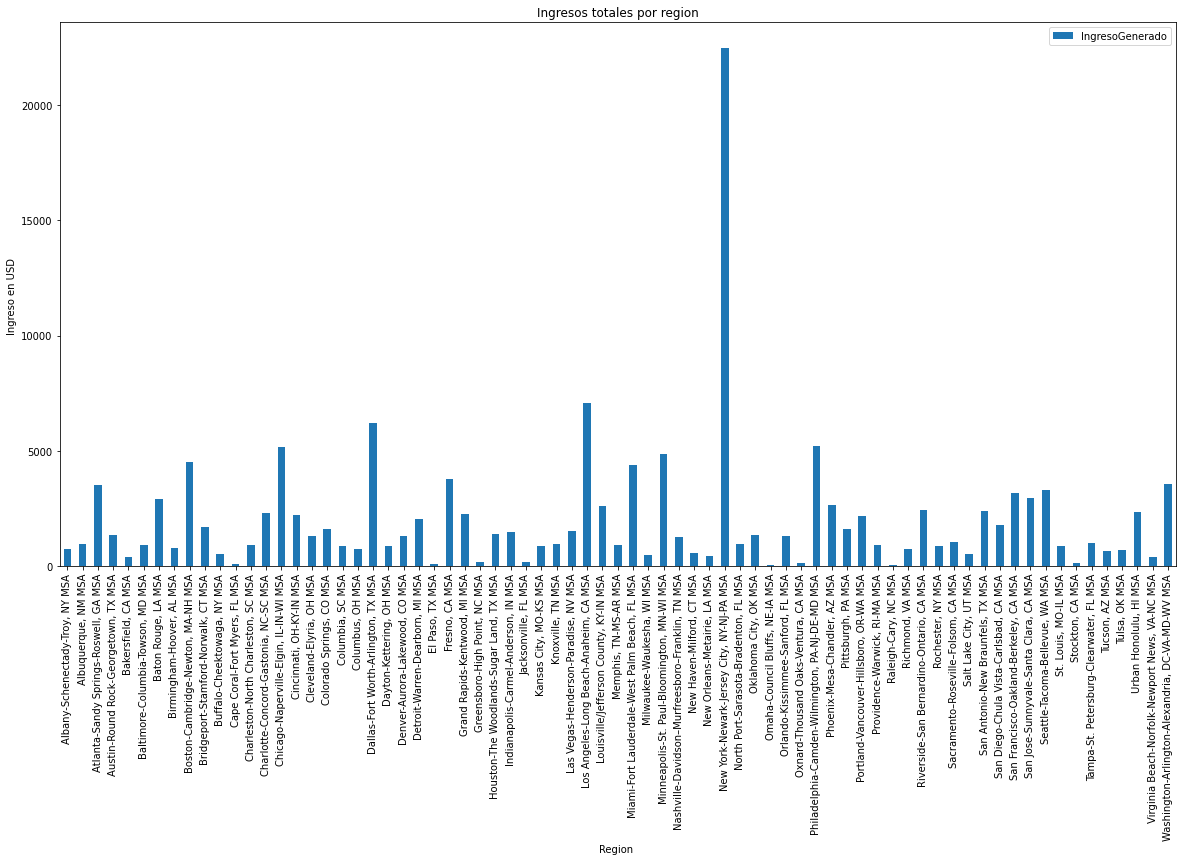

In [61]:

CiudadIngresoTotal.plot( 
    x= 'city',
        y = 'IngresoGenerado', 
        title='Ingresos totales por region',
        kind = 'bar',
        xlabel='Region ',
        ylabel='Ingreso en USD ',
         figsize=(20, 10))



plt.show()

Podemos ver en la grafica que los ingresos de la zona de Nueva York, son mucho mayores que cualquier otra zona individualmente. Ahora la pregunta es sobre le ingreso promedio, para ello tenemos que dividir esos ingresos entre el total de la poblacion para poder asi comparar  

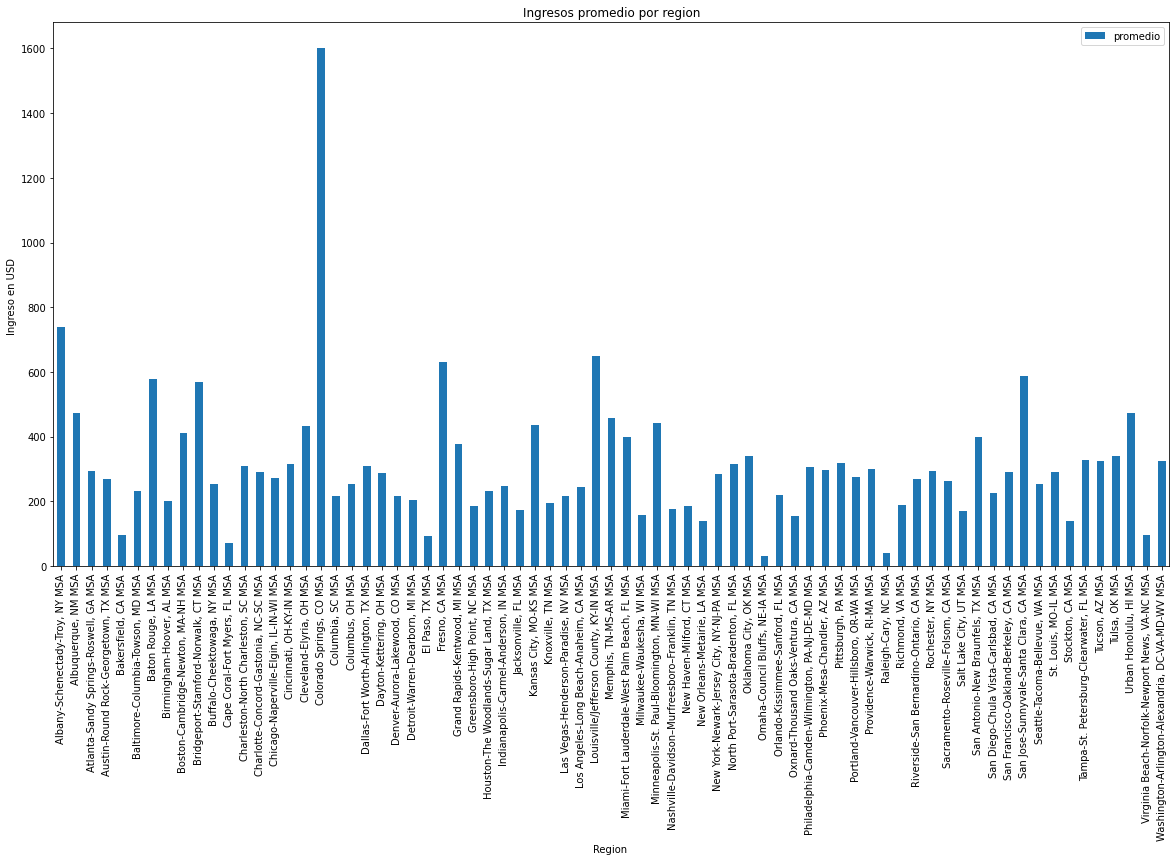

In [62]:
#vamos a dividir el total de ingresos entre la poblacion 

CiudadIngresoTotal['promedio'] = CiudadIngresoTotal['IngresoGenerado']/CiudadIngresoTotal['user_id']


CiudadIngresoTotal.plot( 
    x= 'city',
        y = 'promedio', 
        title='Ingresos promedio por region',
        kind = 'bar',
        xlabel='Region ',
        ylabel='Ingreso en USD ',
         figsize=(20, 10))



plt.show()



Podemos ver que cuando se hace la grafica con base a los ingresos promedio nueva york queda al nivel de otras de forma que la region que tiene el mayor numero de ingresos promedio es Colorado Springs. 
Finalmente haremos una prueba estadistica 

In [63]:
#primero hacemos una serie con todos menos nueva york 
PromedioSinNuevaYork = CiudadIngresoTotal[CiudadIngresoTotal['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']
NY_NJ_Mean = CiudadIngresoTotal[CiudadIngresoTotal['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['promedio'] 


alpha = 0.05  #Elegimos 5% para hacer las pruebas. 

results = st.ttest_1samp(PromedioSinNuevaYork['promedio'], NY_NJ_Mean)

# prueba bilateral : 
display (results.pvalue)

# prueba unilateral a la izquierda:
# rechaza la hipótesis solo si la media muestral es significativamente menor que el valor propuesto

43    0.287803
Name: promedio, dtype: float64

Nuestro valor de P es mucho mayor que el alpha, por lo que no podemos rechazar la hipotesis nula. Esto coincide con lo visto en la grafica de promedio donde vemos que la media de nueva york es similar a la de otras regiones. 

## Conclusión general

[En esta sección final, enumera tus conclusiones importantes. Asegúrate de que estas abarquen todas las decisiones (suposiciones) importantes que adoptaste y que determinaron la forma elegida para procesar y analizar los datos.]

Para este estudio se utilizaron 500 datos de usuarios. Se limpiaron las bases de datos, se compaginaron y analizaron de forma individual el comportamiento de llamadas, mensajes, internet, e ingresos. Se realizaron pruebas de hipotesis para ver si habia diferencia entre el promedio de ingresos de ambos planes y luego se reviso por region comparando la region de Ny-NJ con las otras se pueden llegar a las siguientes conclusiones:  de limpiar las bases de datos, analizar y compaginar la informacion. Se pueden llegar a las siguientes conclusiones: 
1. Los usuarios de Surf son en promedio, mas propensos a pasarse del limite de sus planes. Esto lo vemos en llamadas, mensajes e internet donde habia mas usuarios que se pasaban de los que les otorgaba el plan. 
2. Asi mismo comparando con los usuarios de ultimate, el uso de datos, mensajes y llamadas era similar en cuanto al numero. 
3. Los usuarios de Surf representan un mayor porcentaje de ingresos para la empresa pero son cerca del 60% de los usuarios. Cuando ajustamos a la proporcion de usuarios con el % de ingresos, el promedio de ingresos de ambos planes es similar. 
4. En cuanto al calculo de regiones, los usuarios de Ny-NJ representan un mayor numero de ingresos en total pero al promediarlo con otras regiones con el numero de usuarios, su ingreso promedio es similar al de otras regiones. 
5. Un factor importante en los datos es el bajo numero de usuarios a principios de anio. Esto ocasiona que los calculos de los meses de Enero a Abril sean con pocos usuarios mientras que los de los ultimos meses sean ya con la poblacion completa. 